# Sources of Concept Ambiguity

Examples extracted from column ```concept_synonym_name``` of the ```synonyms``` dataframe:

### Severity Modifier in Base Concept
- ```Vulval intraepithelial neoplasia```
- ```Vulval intraepithelial neoplasia (VIN)```
- ```Vulval intraepithelial neoplasia (disorder)```
- ```Vulval intraepithelial neoplasia grade 3```
- ```Vulval intraepithelial neoplasia grade 3 (disorder)```
- ```Vulval intraepithelial neoplasia grade III```

### Ambiguity in Scale of Severity Modifier in Concept:

- ```Mucopolysaccharidosis type I```
- ```Mucopolysaccharidosis type I (disorder)```
- ```Mucopolysaccharidosis type II```
- ```Mucopolysaccharidosis type II (disorder)```
- ```Mucopolysaccharidosis type VI```
- ```Mucopolysaccharidosis, MPS-I```
- ```Mucopolysaccharidosis, MPS-II```
- ```Mucopolysaccharidosis, MPS-VI```

### Conjunction in Concept

- ```Panic disorder with agoraphobia```
- ```Panic disorder with agoraphobia (disorder)```
- ```Panic disorder with agoraphobia AND mild panic attacks```
- ```Panic disorder with agoraphobia AND mild panic attacks (disorder)```
- ```Panic disorder with agoraphobia AND moderate panic attacks```
- ```Panic disorder with agoraphobia AND moderate panic attacks (disorder)```
- ```Panic disorder with agoraphobia AND panic attacks in full remission```
- ```Panic disorder with agoraphobia AND panic attacks in full remission (disorder)```
- ```Panic disorder with agoraphobia AND panic attacks in partial remission```
- ```Panic disorder with agoraphobia AND panic attacks in partial remission (disorder)```
- ```Panic disorder with agoraphobia AND severe panic attacks```
- ```Panic disorder with agoraphobia AND severe panic attacks (disorder)```

### Multiple Causes and Versions

For "malnutrition":
- ```Malnutrition```
- ```Malnutrition (calorie)```
- ```Malnutrition (calorie) (disorder)```
- ```Malnutrition, calorie```

For "severe combined immunodeficiency":
- ```Severe combined immunodeficiency```
- ```Severe combined immunodeficiency (SCID) due to absent peripheral T cell maturation```
- ```Severe combined immunodeficiency disease```
- ```Severe combined immunodeficiency disease (disorder)```
- ```Severe combined immunodeficiency due to absent peripheral T cell maturation```
- ```Severe combined immunodeficiency due to absent peripheral T cell maturation (disorder)```
- ```Severe combined immunodeficiency with low T- and B-cell numbers```
- ```Severe combined immunodeficiency with low T- and B-cell numbers (disorder)```

### Consolidating (Finding) and (Disorder)

- ```Severe persistent allergic asthma```
- ```Severe persistent allergic asthma (disorder)```
- ```Severe persistent allergic asthma controlled```
- ```Severe persistent allergic asthma controlled (finding)```
- ```Severe persistent allergic asthma uncontrolled```
- ```Severe persistent allergic asthma uncontrolled (finding)```

### Expanded Acroyms

- ```SCID```
- ```SCID - Severe combined immunodeficiency```

### Unexpanded Acronyms

- ```TAG score observations```

### American vs. British English

- ```Sideroachrestic anaemia```
- ```Sideroachrestic anemia```
- ```Sideroblastic anaemia```
- ```Sideroblastic anemia```

### Hyphens

Also refer to "malnutrition" under "Multiple Causes and Versions"
- ```Protein calorie malnutrition```
- ```Protein-calorie malnutrition```
- ```Protein-calorie undernutrition```
- ```Protein-energy malnutrition```


In [416]:
import pandas as pd
import numpy as np
import os
from collections import Counter
import matplotlib.pyplot as plt
% matplotlib inline

from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV

In [277]:
# dump extracted_parents.csv into pandas DataFrame
extracted = pd.read_csv('extracted_parents.csv', sep = ',')
# Check for missing criteria strings in df
print(extracted['criteria_string'].isnull().sum())
# Remove missing criteria strings in df
extracted = extracted.dropna(how = 'any')
# Confirm missing criteria are removed in df
print(extracted['criteria_string'].isnull().sum())
# Reset index after drop
extracted = extracted.reset_index(drop = True)
# Export extracted df to .csv file
extracted.to_csv('cleaned_extracted_parents.csv', encoding = 'utf-8', index = False)

# Top 100 rows serve as validation set
validation_extracted = extracted.head(n = 100)
# Export validation df to .csv file
validation_extracted.to_csv('validation_extracted_parents.csv', encoding = 'utf-8', index = False)

# Remaining rows serve as training set
train_extracted = extracted.tail(n = extracted.shape[0] - 101)
# Reset index after drop
train_extracted = train_extracted.reset_index(drop = True)
# Export training df to .csv file
train_extracted.to_csv('train_extracted_parents.csv', encoding = 'utf-8', index = False)

18165
0


In [5]:
## UNCOMMENT TO REMOVE CRITERIA STRING THAT DO NOT INCLUDE THE MATCHED STRING

# extracted = pd.read_csv('cleaned_extracted_parents.csv', sep = ',')
# print('Number of rows in original dataframe: {}'.format(extracted.shape))

# indices = [] ; matches = [] ; criteria = []
# for idx, criteria_string in enumerate(list(extracted['criteria_string'])) :
#     if (extracted.loc[idx]['matched_string'] in criteria_string) == False :
#         indices.append(idx)
#         matches.append(extracted.loc[idx]['matched_string'])
#         criteria.append(criteria_string)
        
# print('Number rows missing relevant matched_string value: {}'.format(len(indices)))

# extracted = extracted.drop(indices)
# extracted = extracted.reset_index(drop = True)
# confirmation_bool = (extracted.shape[0] == (292320 - 62395))
# print('Confirm all rows with missing relevant matched_string value are dropped: {}'.format(confirmation_bool))

# extracted.to_csv('cleaned_extracted_parents.csv', encoding='utf-8', index=False)

# parents_validation_set = extracted.head(n = 100)
# parents_validation_set.to_csv('validation_extracted_parents.csv', encoding='utf-8', index=False)

# train_extracted = extracted.tail(n = extracted.shape[0] - 101)
# train_extracted.to_csv('train_extracted_parents.csv', encoding='utf-8', index=False)

##  Goal: Develop a method to go from matches parent concepts to the appropriate child concept. Suggest trying all of the parents children’s SYNONYMS as candidates for the match. All data and explanation are in the repo

### From ```find_modified_concepts.ipynb```:
### Concept names vs synonyms

We want concepts that have either one of the modifiers in the `concept_name` or in the name of a synonym. Morbid obesity is a good example of this.

| concept_id |	concept_name |	domain_id |	concept_code |	concept_synonym_name |
| -- |	-- |	-- |	-- |	-- |
| 40565487 |	Morbid obesity |	Condition	| 389986000 | OBESITY, SEVERE |
| 40565487 |	Morbid obesity |	Condition	| 389986000 | Severe obesity |
| 40565487 |	Morbid obesity |	Condition	| 389986000 | obesity severe |
| 40565487 |	Morbid obesity |	Condition	| 389986000 | severe obesity	 |

A couple more good examples are below.

| concept_id |	concept_name |	domain_id |	concept_code |	concept_synonym_name |
| -- |	-- |	-- |	-- |	-- |
| 440370 |	Nutritional marasmus |	Condition |	29740003 |	Severe malnutrition |
| 256716 |	Asthma with status asthmaticus |	Condition | 	57546000 |	acute severe asthma	 |

## `data/extracted_parents.csv`
`data/extracted_parents.csv.xz` is a compressed `.csv` file, which has the following columns:

```
NCT_id, matched_string, criteria_string, parent_concept_id, parent_concept_name
```

The meaning of these columns is as follows:

| **Column Header** | **Definition** |
| :---: |	:---: |
|`NCT_id` | the inclusion/exclusion criteria for the trial. Each `NCD_id` can appear multiple times. |
| `matched_string` | the string that was matched in the criteria. These are synonyms of parent concepts. | 
| `criteria_string` | the string in which the `matched_string` was matched. These are 100 characters on either side of the start of the `matched_string`. |
| `parent_concept_id` | the ID of the concept corresponding to `matched_string` |
| `parent_concept_name` |  the preferred name corresponding to the `parent_concept_id` |

In [4]:
extracted.head(n = 8)

,NCT_id,matched_string,criteria_string,parent_concept_id,parent_concept_name
0,NCT01828931,psychotic disorder,1. Between the ages of 18 and 70 years (i...,436073,Psychotic disorder
1,NCT01829815,disability,- Resident in one of five study sit...,4052648,Disability
2,NCT01823770,scid,e referred for a structured clinical\n ...,29783,Severe combined immunodeficiency disease
3,NCT01823770,painful,tor.\n\n 4. Subject has addition...,4329041,Pain
4,NCT01823770,pain,tor.\n\n 4. Subject has addition...,4329041,Pain
5,NCT01823770,dermatitis,"he study\n medication, such a...",45766714,Inflammatory dermatosis
6,NCT01823770,dementia,"y disorder, painful legs, and moving toes.\n\n...",4182210,Dementia
7,NCT01826240,psychosis,"tive treatment (e.g., receiving psychiatric me...",436073,Psychotic disorder


In [169]:
synonyms.tail()

,parent_concept_id,parent_concept_name,parent_concept_code,concept_synonym_name
2773,380097.0,Diabetic macular edema,312912001.0,Diabetic macular oedema
2774,380097.0,Diabetic macular edema,312912001.0,Macular edema co-occurrent and due to diabetes...
2775,4255402.0,O/E - left eye diabetic maculopathy,408416008.0,O/E - left eye diabetic maculopathy
2776,4255402.0,O/E - left eye diabetic maculopathy,408416008.0,On examination - left eye diabetic maculopathy
2777,4255402.0,O/E - left eye diabetic maculopathy,408416008.0,On examination - left eye diabetic maculopathy...


In [166]:
# print(*extracted.head(n = 8)['criteria_string'], sep = '\n')

In [306]:
# temp = train_extracted.head(n = 3)

# def clean_string_list(input_list) :
#     output_list = []
#     for s in input_list:
#         chars_to_ignore = [',', '.', ':', ';', '(', ')', '[', ']', '#', '%', '<', '>', '/']
#         for char in chars_to_ignore :
#             s = s.replace(char , ' ')
#         s = s.split(' ')
#         s = [str(x).lower() for x in s]
#         s = [str(x).strip() for x in s]
#         s = [x for x in s if (x != '-')]
#         s = [x for x in s if (len(x) >= 3)]
#         s = [x for x in s if not (x.isdigit())]
#         s = [x for x in s if x]
#         output_list.append(s)
        
#     return output_list

# for origin, cleaned in zip(list(temp['criteria_string']), clean_string_list(list(temp['criteria_string']))):
#     print('ORIGIN: {}'.format(origin))
#     print('CLEANED: {}'.format(cleaned), '\n\n')

# # print(*list(temp['criteria_string']), sep = '\n')
# # print(*clean_string_list(list(temp['criteria_string'])), sep = '\n')

In [91]:
# # CODE TO GENERATE ONE-HOT ENCODED VALUES FOR 

# temp = train_extracted.head(n = 100).copy()
# criteria_split = []
# for s in list(temp['criteria_string']) :
#     chars_to_ignore = [',', '.', ':', ';', '(', ')', '[', ']', '#', '%', '<', '>', '/']
#     for char in chars_to_ignore :
#         s = s.replace(char , ' ')
#     s = s.split(' ')
#     s = [str(x).lower() for x in s]
#     s = [str(x).strip() for x in s]
#     s = [x for x in s if (x != '-')]
#     s = [x for x in s if (len(x) >= 3)]
#     s = [x for x in s if not (x.isdigit())]
#     s = [x for x in s if x]
#     criteria_split.append(s)
    
# temp['criteria_split'] = criteria_split
# temp.drop('criteria_string', axis = 1)

# mlb = MultiLabelBinarizer()
# one_hot_df = pd.DataFrame(mlb.fit_transform(temp.pop('criteria_split')),
#                           columns = mlb.classes_,
#                           index = temp.index)
# temp = temp.join(one_hot_df)

# # temp = temp[temp.columns.difference(['NCT_id', 'matched_string'])]
# temp.head(n = 10)

In [156]:
# criteria_split

In [2]:
# Extracted parents.csv
# parents to synonyms.tsv

FILE_ROOT_PATH = 'computed/'
CONCEPTS_PATH = FILE_ROOT_PATH + 'concepts_with_modifiers.tsv'
PARENT_PATH = FILE_ROOT_PATH + 'parent_to_descendant_synonyms.tsv' # 
PARENT_SYNONYM_PATH = FILE_ROOT_PATH + 'parents_synonyms.tsv'
PARENT_MODIFIED_CHILDREN_PATH = FILE_ROOT_PATH + 'parents_with_modified_children.tsv'

In [57]:
synonyms.head()

,parent_concept_id,parent_concept_name,parent_concept_code,concept_synonym_name
0,4039266.0,Dry skin,16386004.0,Anhydrotic skin
1,4039266.0,Dry skin,16386004.0,Dry skin (finding)
2,4039266.0,Dry skin,16386004.0,Dry skin
3,443432.0,Impaired cognition,386806002.0,Cognitive disturbance
4,443432.0,Impaired cognition,386806002.0,Cognitive dysfunction


In [100]:
print(set(train_extracted['parent_concept_id']).issubset(set(synonyms['parent_concept_id'])))
len((set(synonyms['parent_concept_id'])) - set(train_extracted['parent_concept_id']))

True


231

# Import Data and Data Exploration

In [251]:
concepts = pd.read_csv(CONCEPTS_PATH, sep = '\t')
parents = pd.read_csv(PARENT_PATH, sep = '\t')
synonyms = pd.read_csv(PARENT_SYNONYM_PATH, sep = '\t')
modified = pd.read_csv(PARENT_MODIFIED_CHILDREN_PATH, sep = '\t')

concepts = concepts.drop_duplicates()
concepts.reset_index(drop = True)
parents = parents.drop_duplicates()
parents.reset_index(drop = True)
synonyms = synonyms.drop_duplicates()
synonyms = synonyms.dropna(how = 'all')
synonyms.reset_index(drop = True)
modified = modified.drop_duplicates()
modified = modified.dropna(how = 'any')
modified.reset_index(drop = True)

# Get shape 
print('Concepts ', concepts.shape,'\n',list(concepts.columns))
print('Parents ', parents.shape,'\n',list(parents.columns))
print('Synonyms ', synonyms.shape, '\n',list(synonyms.columns))
print('Modified Children', modified.shape,'\n',list(modified.columns))

print('\nUniqueness of concept ids within each dataframe')
print('Concepts:', concepts.shape[0] - len(concepts[concepts.columns[0]]) == 0)
print('Parents:', parents.shape[0] - len(parents[parents.columns[0]]) == 0)
print('Synonyms:', synonyms.shape[0] - len(synonyms[synonyms.columns[0]]) == 0)
print('Modified Children:', modified.shape[0] - len(modified[modified.columns[0]]) == 0)

Concepts  (597, 3) 
 ['concept_id', 'concept_name', 'concept_code']
Parents  (279070, 3) 
 ['parent_concept_id', 'descendant_concept_id', 'descendant_synonym_name']
Synonyms  (1541, 4) 
 ['parent_concept_id', 'parent_concept_name', 'parent_concept_code', 'concept_synonym_name']
Modified Children (835, 6) 
 ['modified_concept_id', 'modified_concept_name', 'modified_concept_code', 'parent_concept_id', 'parent_concept_name', 'parent_concept_code']

Uniqueness of concept ids within each dataframe
Concepts: True
Parents: True
Synonyms: True
Modified Children: True


In [233]:
modified.head(n=10)

,modified_concept_id,modified_concept_name,modified_concept_code,parent_concept_id,parent_concept_name,parent_concept_code
0,45765743,Severe dry skin,702757002,4039266.0,Dry skin,16386004.0
1,45765900,Severe cognitive impairment,702956004,443432.0,Impaired cognition,386806002.0
2,45766192,Severe hypoxic ischemic encephalopathy,703303004,45766189.0,Hypoxic ischemic encephalopathy,703300001.0
3,40479642,Pneumonia due to Severe acute respiratory synd...,441590008,320651.0,Severe acute respiratory syndrome,398447004.0
4,40479642,Pneumonia due to Severe acute respiratory synd...,441590008,37016927.0,Pneumonia caused by Human coronavirus,713084008.0
5,42872411,"Severe major depression, single episode",251000119105,42872722.0,Severe major depression,450714000.0
6,42872411,"Severe major depression, single episode",251000119105,4282096.0,"Major depression, single episode",36923009.0
7,42872412,Severe mixed bipolar I disorder,271000119101,443906.0,Mixed bipolar I disorder,16506000.0
8,42872412,Severe mixed bipolar I disorder,271000119101,4154283.0,Severe bipolar I disorder,371599001.0
9,42872413,Severe depressed bipolar I disorder,261000119107,441836.0,Depressed bipolar I disorder,49468007.0


In [317]:
unique_parent_concepts = list(synonyms['parent_concept_name'])
# Remove redundant values in list
unique_parent_concepts = list(set(unique_parent_concepts))
# Cast all elements of list to strings
unique_parent_concepts = [str(x) for x in unique_parent_concepts]
# Sort alphabetically
unique_parent_concepts.sort()
# Number of unique parent concepts
print(len(unique_parent_concepts))

460


In [15]:
# unique_parent_codes = {}
# for concept in unique_parent_concepts :
#     if concept in list(synonyms['parent_concept_name']) :
#         parent_code = int(synonyms[synonyms['parent_concept_name'] == concept]['parent_concept_id'].values[0])
#         unique_parent_codes[concept] = parent_code

# # unique_parent_codes = list(set(unique_parent_codes))
# # unique_parent_codes = list(unique_parent_codes.values())
# len(unique_parent_codes)

In [312]:
# unique_parent_codes = {}
# unique_parent_vocab = []
# for concept in unique_parent_concepts :
#     if concept in list(synonyms['parent_concept_name']) :
#         parent_code = int(synonyms[synonyms['parent_concept_name'] == concept]['parent_concept_code'].values[0])
#         unique_parent_codes[concept] = parent_code
#     if '-' in concept: concept = concept.replace('-', ' ')
#     if '[X]' in concept: concept = concept.replace('[X]', ' ')
#     if ',' in concept: concept = concept.replace(',', ' ')
#     current_vocab = concept.split(' ')
#     current_vocab = [str(x).lower() for x in current_vocab]
#     current_vocab = [x for x in current_vocab if len(x) >= 3]
#     unique_parent_vocab.append(current_vocab)
    
# unique_parent_vocab[0:10]

In [313]:
# len(unique_parent_concepts)

In [311]:
# # '[X]CONCEPT' -> 'CONCEPT'
# unique_parent_concepts = [x.replace('[X]','') for x in unique_parent_concepts]

# base_df = pd.DataFrame(list(zip(unique_parent_concepts, unique_parent_vocab)),
#                        columns = ['parent_concept','parent_vocabulary'])

# base_df['parent_concept_code'] = base_df['parent_concept'].map(unique_parent_codes)

# # Sort alphabetically
# base_df.sort_values('parent_concept')
# # Number of unique parent concepts
# print(len(base_df))
# base_df.tail()

In [298]:
# list(synonyms[synonyms['parent_concept_code'] == 86268005.0]['concept_synonym_name'])

In [309]:
# mlb = MultiLabelBinarizer()
# base_concept_df = pd.DataFrame(mlb.fit_transform(base_df['parent_vocabulary']),
#                                columns = mlb.classes_,
#                                index = base_df.index)
# base_concept_df.sum(axis = 0)[0:10]

In [315]:
# vocab_counts = base_concept_df.sum(axis = 0).sort_values(ascending = True)
# vocab_counts[0:10]

In [310]:
# sparsest = []
# for word, count in vocab_counts.items():
#     if count < 3 :
#         sparsest.append(word)
#         # print(word, count)
        
# print(len(sparsest))

In [22]:
# sparsest.sort()
# sparsest

In [23]:
# labels, counts = zip(*Counter(synonyms['parent_concept_name']).items())
# # labels_and_counts.sort()
# counts, labels = zip(*sorted(zip(counts, labels), reverse = True))
# indexes = np.arange(len(labels))
# width = 0.5
# plt.figure(figsize = (30, 4))
# plt.bar(indexes, counts, width)
# # plt.xticks(indexes + width * 1, labels, rotation='vertical')
# plt.show()

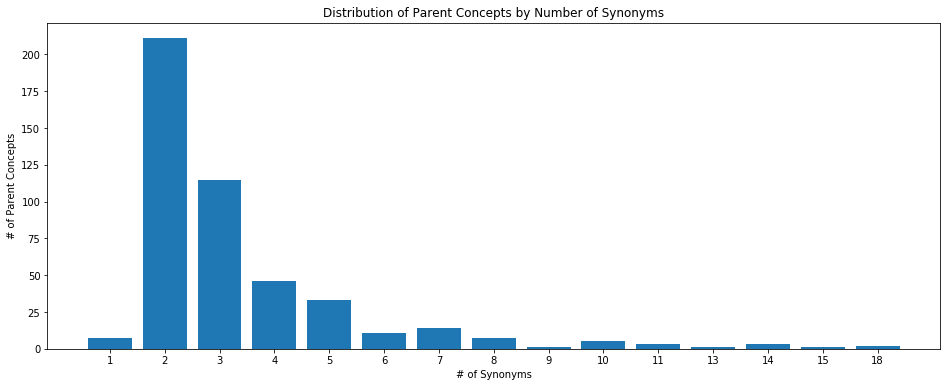

In [254]:
_, counts = zip(*Counter(synonyms['parent_concept_id']).items())
count_of_counts = dict(Counter(counts))
plt.figure(figsize = (16, 6))
plt.bar(range(len(count_of_counts)), list(count_of_counts.values()), align='center')
plt.title('Distribution of Parent Concepts by Number of Synonyms')
plt.ylabel('# of Parent Concepts')
plt.xlabel('# of Synonyms')
plt.xticks(range(len(count_of_counts)), list(count_of_counts.keys()))
plt.show()

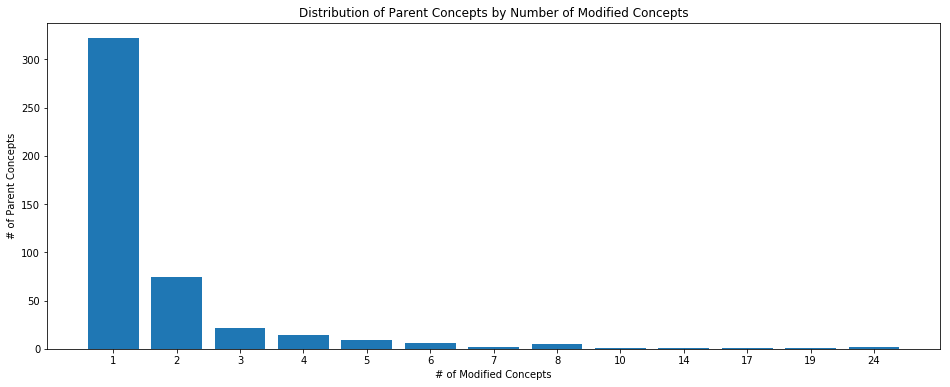

In [303]:
_, counts = zip(*Counter(modified['parent_concept_id']).items())
count_of_counts = dict(Counter(counts))
plt.figure(figsize = (16, 6))
plt.bar(range(len(count_of_counts)), list(count_of_counts.values()), align='center')
plt.title('Distribution of Parent Concepts by Number of Modified Concepts')
plt.ylabel('# of Parent Concepts')
plt.xlabel('# of Modified Concepts')
plt.xticks(range(len(count_of_counts)), list(count_of_counts.keys()))
plt.show()

In [28]:
# indices = len(count_of_counts)
# plt.bar(indices, count_of_counts)

In [240]:
# def plot_parent_label_counts(n_labels, title = None, horizontal = False) :
#     labels, counts = zip(*Counter(synonyms['parent_concept_name']).items())
#     # labels_and_counts.sort()
#     c, l = zip(*sorted(zip(counts, labels), reverse = True))
#     c = c[0:n_labels]
#     l = l[0:n_labels]
#     if title == None : title = 'Top {} Parent Concepts by Synonym Count'.format(n_labels)
#     indexes = np.arange(len(l))
#     width = 0.5
#     if horizontal == False :
#         if n_labels > 25 : plt.figure(figsize = (8 * (n_labels // 20), 6))
#         plt.bar(indexes, c, width)
#         plt.title(title)
#         plt.xticks(indexes + width * 0.25, l, rotation = 'vertical')
#         plt.show()
#     else :
#         if n_labels > 20 : plt.figure(figsize = (8, 6 * (n_labels // 20)))
#         plt.barh(indexes, c, width)
#         plt.title(title)
#         plt.yticks(indexes + width * 0.25, l)
#         plt.show()
    
# plot_parent_label_counts(50, horizontal = True)

In [213]:
# plot_parent_label_counts(45)

In [285]:
# FUNCTIONS TO QUERY AND NAVIGATE DATAFRAMES
def get_synonyms(parent) :
    parent_list = list(synonyms['parent_concept_name'])
    id_list = list(synonyms['parent_concept_id'])
    if parent in parent_list :
        return_df = synonyms[synonyms['parent_concept_name'] == parent]
        return list(return_df['concept_synonym_name'])
    elif parent in id_list :
        return_df =  synonyms[synonyms['parent_concept_id'] == parent]
        return list(return_df['concept_synonym_name'])
    else :
        parent = str(parent)
        parent_list_lower = [str(x).lower() for x in parent_list]
        if parent.lower() in parent_list_lower :
            idx = parent_list_lower.index(parent.lower())
            return_df = synonyms[synonyms['parent_concept_name'] == parent_list[idx]]
            return list(return_df['concept_synonym_name'])
        else :
            print('Parent concept {} does not have synonyms.'.format(parent))
            return None
        
def get_parent_concept_id(parent) :
    parent_list = list(synonyms['parent_concept_name'])
    if parent in parent_list :
        return list(synonyms[synonyms['parent_concept_name'] == parent]['parent_concept_id'])[0]
    else :
        parent_list_lower = [str(x).lower() for x in parent_list]
        if parent.lower() in parent_list_lower :
            idx = parent_list_lower.index(parent.lower())
            return list(synonyms[synonyms['parent_concept_name'] == parent_list[idx]]['parent_concept_id'])[0]
        else :
            print('Parent concept {} not found.'.format(parent))
            return None

# def get_modified_concept_df(parent):
#     synonym_list = list(synonyms['parent_concept_name'])
#     code_list = list(synonyms['parent_concept_code'])
#     if parent in synonym_list :
#         if parent in list(modified['parent_concept_name']) :
#             return modified[modified['parent_concept_name'] == parent]
#         else :
#             print('Concept {} does not have modified descendents'.format(parent))
#         parent_concept_name
#     elif parent in code_list :
#         if parent in list(modified['parent_concept_code']) :
#             return modified[modified['parent_concept_code'] == parent]
#         else :
#             print('Concept code {} does not have modified descendents'.format(parent))
#     else :
#         print('Parent concept {} does not have modified descendants.'.format(parent))
#         return None

In [286]:
print(*get_synonyms(380097.0), sep = '\n')
print('\n')
print(get_synonyms(380097.0) == get_synonyms('Diabetic macular edema') == get_synonyms('DIABETIC MACULAR EDEMA'))

Diabetic macular edema
Macular oedema due to diabetes mallitus
Macular oedema co-occurrent and due to diabetes mellitus
Macular edema due to diabetes mellitus
Macular edema co-occurrent and due to diabetes mellitus (disorder)
Diabetic macular oedema
Macular edema co-occurrent and due to diabetes mellitus


True


In [287]:
print(get_parent_concept_id('Diabetic macular edema'))
print(get_parent_concept_id('DIABETIC MACULAR EDEMA'.upper()))

380097.0
380097.0


In [196]:
get_modified_concept_df('Diabetic macular oedema')

Parent concept Diabetic macular oedema does not have modified descendants.


In [39]:
get_modified_concept_df(4265433.0)

Parent concept 4265433.0 does not have modified descendants.


In [305]:
validation_extracted.head()

,NCT_id,matched_string,criteria_string,parent_concept_id,parent_concept_name
0,NCT01828931,psychotic disorder,1. Between the ages of 18 and 70 years (i...,436073,Psychotic disorder
1,NCT01829815,disability,- Resident in one of five study sit...,4052648,Disability
2,NCT01823770,scid,e referred for a structured clinical\n ...,29783,Severe combined immunodeficiency disease
3,NCT01823770,painful,tor.\n\n 4. Subject has addition...,4329041,Pain
4,NCT01823770,pain,tor.\n\n 4. Subject has addition...,4329041,Pain


# Matching

In [318]:
# print(*list(validation_extracted['parent_concept_name']), sep = '\n')

In [321]:
get_synonyms(436073)

['Psychotic disorder (disorder)', 'Psychotic disorder', 'Psychosis']

In [364]:
synonym_list = []
for concept_id in validation_extracted['parent_concept_id'] :
    synonym_list.append(get_synonyms(concept_id))

# validation_extracted['synonyms'] = synonym_list
# validation_extracted = validation_extracted.drop('synonyms', axis = 1)
# validation_extracted.head()

In [365]:
# NUMBER OF PARENT CONCEPTS IN VALIDATION SET
validation_concept_ids = sorted(list(set(validation_extracted['parent_concept_id'])))
print(len(validation_concept_ids))

36


In [421]:
# validation_extracted

In [457]:
validation_extracted.head(n = 30)

,NCT_id,matched_string,criteria_string,parent_concept_id,parent_concept_name
0,NCT01828931,psychotic disorder,1. Between the ages of 18 and 70 years (i...,436073,Psychotic disorder
1,NCT01829815,disability,- Resident in one of five study sit...,4052648,Disability
2,NCT01823770,scid,e referred for a structured clinical\n ...,29783,Severe combined immunodeficiency disease
3,NCT01823770,painful,tor.\n\n 4. Subject has addition...,4329041,Pain
4,NCT01823770,pain,tor.\n\n 4. Subject has addition...,4329041,Pain
5,NCT01823770,dermatitis,"he study\n medication, such a...",45766714,Inflammatory dermatosis
6,NCT01823770,dementia,"y disorder, painful legs, and moving toes.\n\n...",4182210,Dementia
7,NCT01826240,psychosis,"tive treatment (e.g., receiving psychiatric me...",436073,Psychotic disorder
8,NCT01826240,mental retardation,"ia, psychosis, Obsessive-Compulsive Disorder, ...",40277917,Intellectual disability
9,NCT01826721,cognitive impairment,) or sirolimus\n\n - attending the S...,443432,Impaired cognition


In [373]:
training = train_extracted[train_extracted['parent_concept_id'].isin(validation_concept_ids)].copy()
training = training.reset_index(drop = True)

In [374]:
all_values = pd.concat([validation_extracted, training], ignore_index=True)
all_values.head()

,NCT_id,matched_string,criteria_string,parent_concept_id,parent_concept_name
0,NCT01828931,psychotic disorder,1. Between the ages of 18 and 70 years (i...,436073,Psychotic disorder
1,NCT01829815,disability,- Resident in one of five study sit...,4052648,Disability
2,NCT01823770,scid,e referred for a structured clinical\n ...,29783,Severe combined immunodeficiency disease
3,NCT01823770,painful,tor.\n\n 4. Subject has addition...,4329041,Pain
4,NCT01823770,pain,tor.\n\n 4. Subject has addition...,4329041,Pain


In [472]:
# CODE TO GENERATE ONE-HOT ENCODED VALUES FOR CRITERIA STRING

def get_data(concept_id) :
    temp = all_values[all_values['parent_concept_id'] == concept_id].copy()
    y, label = pd.factorize(temp.matched_string)
    temp['y'] = y
    criteria_split = []
    for s in list(temp['criteria_string']) :
        chars_to_ignore = [',', '.', ':', ';', '(', ')', '[', ']', '#', '%', '<', '>', '/', '"', '*', '-', '―']
        for char in chars_to_ignore :
            s = s.replace(char , ' ')
        s = s.split(' ')
        s = [str(x).lower() for x in s]
        s = [str(x).strip() for x in s]
        s = [x for x in s if (x != '-')]
        s = [x for x in s if (len(x) >= 3)]
        s = [x for x in s if not (x.isdigit())]
        s = [x for x in s if x]
        criteria_split.append(s)

    temp['criteria_split'] = criteria_split
    temp.drop('criteria_string', axis = 1)

    mlb = MultiLabelBinarizer()
    one_hot_df = pd.DataFrame(mlb.fit_transform(temp.pop('criteria_split')),
                              columns = mlb.classes_,
                              index = temp.index)

    X_test = one_hot_df[one_hot_df.index < 100]
    y_test = list(temp[temp.index < 100]['y'])
    X_train = one_hot_df[one_hot_df.index >= 100]
    y_train = list(temp[temp.index >= 100]['y'])

    return label, X_test, y_test, X_train, y_train

label, X_test, y_test, X_train, y_train = get_data(437312)

In [467]:
# y_test

In [468]:
# label[y_test]

In [469]:
# print(X_train.shape)
# X_train.head()

In [474]:
model = LogisticRegression(solver = 'lbfgs', multi_class = 'auto')
model.fit(X_train, y_train)

/anaconda3/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='auto',
          n_jobs=None, penalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)

In [406]:
# model = XGBClassifier()
# n_estimators = range(10, 100, 20)
# param_grid = dict(n_estimators = n_estimators)
# kfold = StratifiedKFold(n_splits = 10, shuffle = True, random_state = 3)
# grid_search = GridSearchCV(model, param_grid, scoring="neg_log_loss", n_jobs=-1, cv=kfold)
# grid_result = grid_search.fit(X_train, y_train)